# Airbus patch classification test

Sample a random Airbus tile, split it into AlexNet-sized patches, and run the classifier on each region to visualize aircraft vs. background predictions.


In [11]:
from pathlib import Path
import random
from typing import List, Dict, Tuple

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import torch
from torchvision.transforms import functional as F

from alexnet_classifier import build_alexnet_classifier, IMAGENET_MEAN, IMAGENET_STD

DATASET_DIR = Path("dataset/airbus-aircrafts-sample-dataset") / "images"
WEIGHTS_PATH = Path("artifacts/alexnet_classifier_weights.pth")
PATCH_SIZE = 224
STRIDE = 224
MODEL_CLASS_ORDER = ("aircraft", "background")
TARGET_CLASS_ORDER = ("background", "aircraft")

if not DATASET_DIR.exists():
    raise FileNotFoundError(f"Dataset directory not found: {DATASET_DIR}")
if not WEIGHTS_PATH.exists():
    raise FileNotFoundError("Classifier weights not found. Run alexnet_classifier_training.ipynb first.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier = build_alexnet_classifier(num_classes=2)
classifier.load_state_dict(torch.load(WEIGHTS_PATH, map_location=device))
classifier.to(device)
classifier.eval()



ClassicAlexNetClassifier(
  (features): ClassicAlexNetFeatureExtractor(
    (blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (3): Sequential(
        (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
      (4): Sequential(
        (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Max

Sample image: 0641acc3-c0b9-4f9d-b0ba-7ad18aa08864.jpg


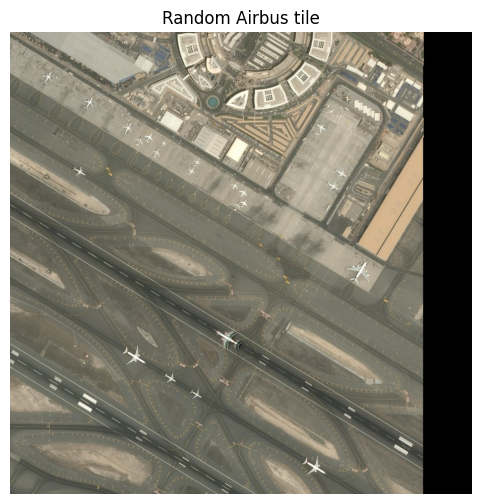

In [12]:
image_paths = sorted(DATASET_DIR.glob("*.jpg"))
if not image_paths:
    raise RuntimeError("No images found in the dataset directory.")

sample_path = random.choice(image_paths)
print(f"Sample image: {sample_path.name}")

image = Image.open(sample_path).convert("RGB")
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title("Random Airbus tile")
plt.axis("off")
plt.show()



In [13]:
def sliding_windows(image: Image.Image, size: int, stride: int) -> List[Dict[str, Tuple[int, int, int, int]]]:
    width, height = image.size
    xs = list(range(0, max(width - size + 1, 1), stride))
    ys = list(range(0, max(height - size + 1, 1), stride))
    if xs[-1] != width - size:
        xs.append(width - size)
    if ys[-1] != height - size:
        ys.append(height - size)

    windows = []
    for top in ys:
        for left in xs:
            bbox = (
                int(max(left, 0)),
                int(max(top, 0)),
                int(min(left + size, width)),
                int(min(top + size, height)),
            )
            windows.append({"bbox": bbox})
    return windows


def preprocess_patch(patch: Image.Image) -> torch.Tensor:
    tensor = F.to_tensor(patch)
    tensor = F.normalize(tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD)
    return tensor


def classify_patches(image: Image.Image, windows: List[Dict[str, Tuple[int, int, int, int]]]):
    patch_tensors = []
    for win in windows:
        crop = image.crop(win["bbox"])
        if crop.size != (PATCH_SIZE, PATCH_SIZE):
            crop = crop.resize((PATCH_SIZE, PATCH_SIZE), Image.BILINEAR)
        patch_tensors.append(preprocess_patch(crop))

    predictions = []
    target_index = torch.tensor(
        [MODEL_CLASS_ORDER.index(cls) for cls in TARGET_CLASS_ORDER], device=device, dtype=torch.long
    )

    with torch.no_grad():
        for start in range(0, len(patch_tensors), 32):
            batch = torch.stack(patch_tensors[start:start + 32]).to(device)
            logits = classifier(batch)
            probs = torch.softmax(logits, dim=1)
            # reorder probabilities so index 0=background, 1=aircraft as expected downstream
            reordered = probs[:, target_index]
            scores, labels = torch.max(reordered, dim=1)
            for idx in range(len(labels)):
                predictions.append({
                    "bbox": windows[start + idx]["bbox"],
                    "label": int(labels[idx].item()),
                    "score": float(scores[idx].item()),
                    "prob_background": float(reordered[idx, 0].item()),
                    "prob_aircraft": float(reordered[idx, 1].item()),
                })
    return predictions


windows = sliding_windows(image, PATCH_SIZE, STRIDE)
print(f"Generated {len(windows)} patches")
patch_predictions = classify_patches(image, windows)
patch_predictions[:3]



Generated 144 patches


[{'bbox': (0, 0, 224, 224),
  'label': 0,
  'score': 0.9999915361404419,
  'prob_background': 0.9999915361404419,
  'prob_aircraft': 8.459403034066781e-06},
 {'bbox': (224, 0, 448, 224),
  'label': 0,
  'score': 0.9999858140945435,
  'prob_background': 0.9999858140945435,
  'prob_aircraft': 1.422887453372823e-05},
 {'bbox': (448, 0, 672, 224),
  'label': 0,
  'score': 0.9999983310699463,
  'prob_background': 0.9999983310699463,
  'prob_aircraft': 1.638345338506042e-06}]

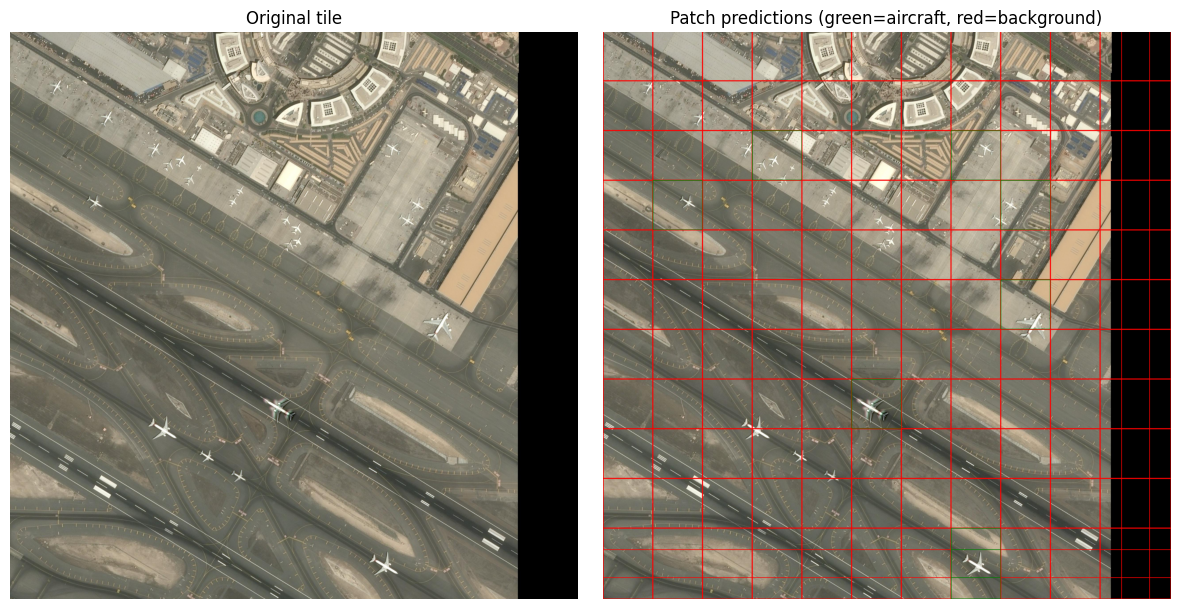

In [14]:
overlay = image.copy()
draw = ImageDraw.Draw(overlay)
for patch in patch_predictions:
    color = "green" if patch["label"] == 1 else "red"
    draw.rectangle(patch["bbox"], outline=color, width=3)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Original tile")
axes[0].axis("off")

axes[1].imshow(overlay)
axes[1].set_title("Patch predictions (green=aircraft, red=background)")
axes[1].axis("off")

plt.tight_layout()
plt.show()



## Patch gallery


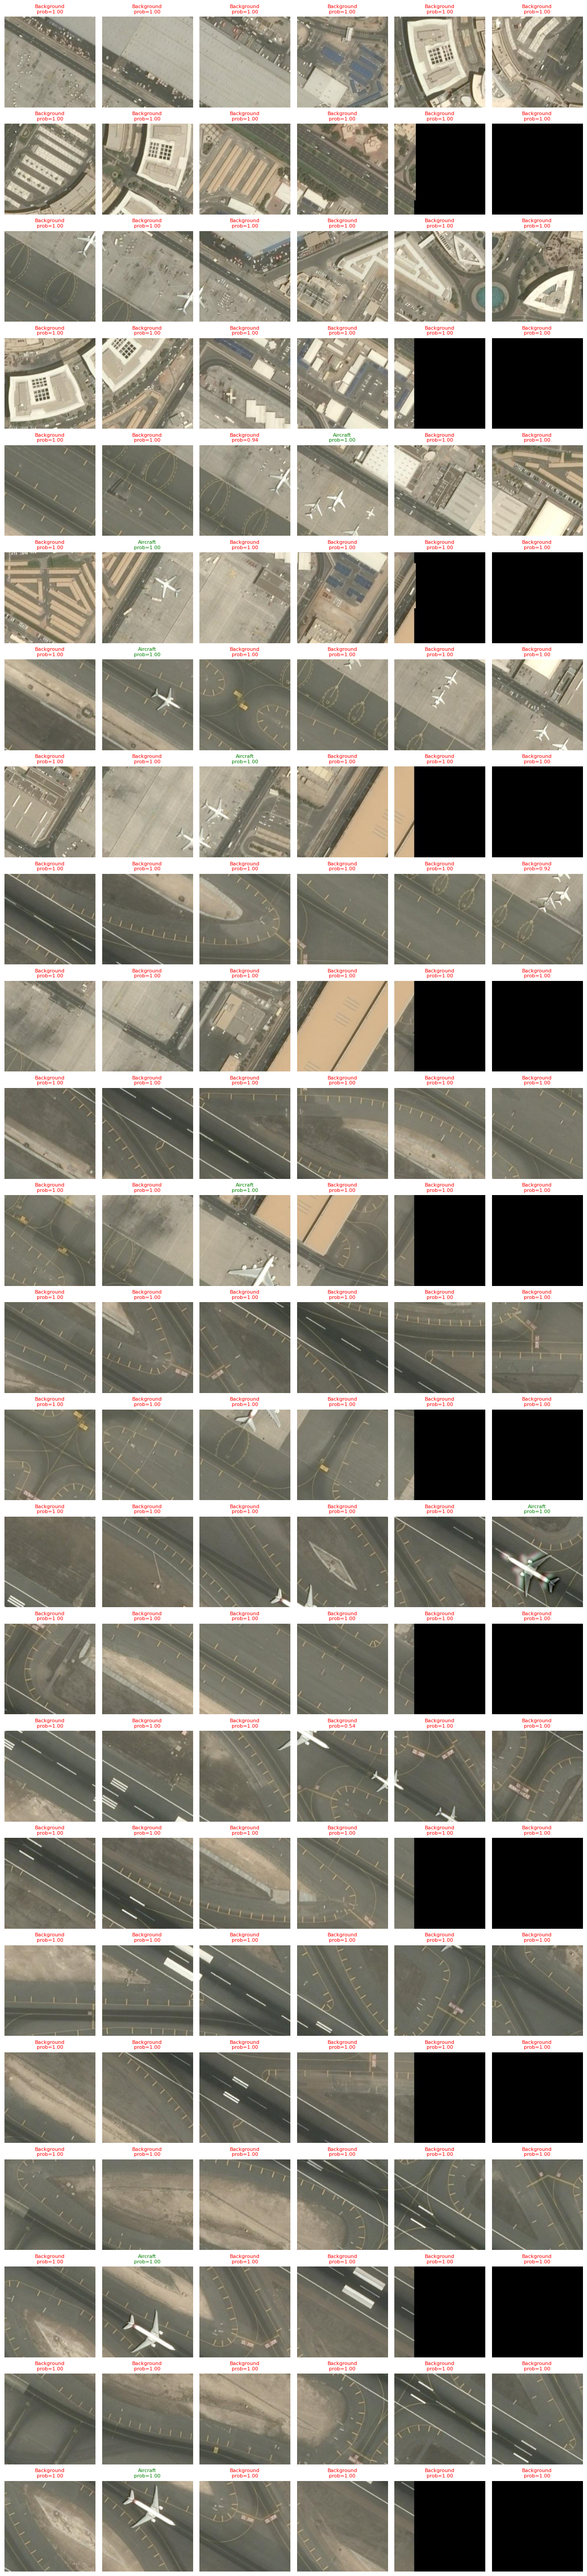

In [15]:
cols = 6
rows = int(np.ceil(len(patch_predictions) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.2, rows * 2.4))
axes = axes.flatten()

for ax, patch in zip(axes, patch_predictions):
    crop = image.crop(patch["bbox"])
    crop = crop.resize((PATCH_SIZE, PATCH_SIZE), Image.BILINEAR)
    label = "Aircraft" if patch["label"] == 1 else "Background"
    color = "green" if patch["label"] == 1 else "red"
    prob = patch["prob_aircraft"] if patch["label"] == 1 else patch["prob_background"]

    ax.imshow(crop)
    ax.set_title(f"{label}\nprob={prob:.2f}", fontsize=8, color=color)
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(2)
    ax.axis("off")

for ax in axes[len(patch_predictions):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

